<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/Mel_specto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Extraction and labeling

In [3]:
import zipfile
import os
import pandas as pd
from glob import glob

# Step 1: Extract the zip file
zip_path = '/content/drive/MyDrive/AD/Mel_Spectrograms.zip'
extract_path = '/content'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed!")
print("Contents of /content:")
print(os.listdir('/content'))

# Check if Mel_Spectrograms folder exists
if 'Mel_Spectrograms' in os.listdir('/content'):
    print("\nMel_Spectrograms folder found!")
    mel_path = '/content/Mel_Spectrograms'
    print("Contents of Mel_Spectrograms:")
    print(os.listdir(mel_path))

    # Check subdirectories
    subdirs = os.listdir(mel_path)
    print(f"\nSubdirectories: {subdirs}")

    for subdir in subdirs:
        subdir_path = os.path.join(mel_path, subdir)
        if os.path.isdir(subdir_path):
            files = os.listdir(subdir_path)
            print(f"Files in {subdir}: {len(files)} files")
            if len(files) > 0:
                print(f"Sample files: {files[:5]}")
else:
    print("Mel_Spectrograms folder NOT found!")
    # List all contents to see what was actually extracted
    for root, dirs, files in os.walk('/content'):
        level = root.replace('/content', '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 2 * (level + 1)
        for file in files:
            print(f'{subindent}{file}')

# Now try to find the correct paths
base_path = '/content/Mel_Spectrograms'
if not os.path.exists(base_path):
    # Try to find where the folder actually is
    for root, dirs, files in os.walk('/content'):
        if 'Mel_Spectrograms' in dirs:
            base_path = os.path.join(root, 'Mel_Spectrograms')
            break

print(f"\nUsing base path: {base_path}")

# Check if AD and CN directories exist
ad_path = os.path.join(base_path, 'AD')
cn_path = os.path.join(base_path, 'CN')

print(f"AD path exists: {os.path.exists(ad_path)}")
print(f"CN path exists: {os.path.exists(cn_path)}")

if os.path.exists(ad_path):
    print(f"AD directory contents: {os.listdir(ad_path)[:10]}")  # Show first 10 files
if os.path.exists(cn_path):
    print(f"CN directory contents: {os.listdir(cn_path)[:10]}")  # Show first 10 files

# Try different file extensions
extensions = ['*.png', '*.jpg', '*.jpeg', '*.npy', '*.npz']
ad_files = []
cn_files = []

for ext in extensions:
    if os.path.exists(ad_path):
        ad_files = glob(os.path.join(ad_path, ext))
        if ad_files:
            print(f"Found {len(ad_files)} AD files with extension {ext}")
            break

for ext in extensions:
    if os.path.exists(cn_path):
        cn_files = glob(os.path.join(cn_path, ext))
        if cn_files:
            print(f"Found {len(cn_files)} CN files with extension {ext}")
            break

# Create labels
labels = [1] * len(ad_files) + [0] * len(cn_files)
file_paths = ad_files + cn_files

print(f"\nTotal AD files: {len(ad_files)}")
print(f"Total CN files: {len(cn_files)}")

# Create DataFrame
df = pd.DataFrame({
    'file_path': file_paths,
    'label': labels
})

print(f"\nDataset shape: {df.shape}")
print("\nFirst few entries:")
print(df.head())

# Save to CSV
if not df.empty:
    df.to_csv('/content/alzheimers_dataset.csv', index=False)
    print("\nDataset saved to /content/alzheimers_dataset.csv")
else:
    print("\nNo files found. Please check the zip file contents.")

Extraction completed!
Contents of /content:
['.config', 'alzheimers_dataset.csv', 'drive', 'Mel_Spectrograms', 'sample_data']

Mel_Spectrograms folder found!
Contents of Mel_Spectrograms:
['AD', 'CN']

Subdirectories: ['AD', 'CN']
Files in AD: 87 files
Sample files: ['adrso063.npy', 'adrso192.npy', 'adrso144.npy', 'adrso110.npy', 'adrso122.npy']
Files in CN: 79 files
Sample files: ['adrso316.npy', 'adrso012.npy', 'adrso310.npy', 'adrso160.npy', 'adrso309.npy']

Using base path: /content/Mel_Spectrograms
AD path exists: True
CN path exists: True
AD directory contents: ['adrso063.npy', 'adrso192.npy', 'adrso144.npy', 'adrso110.npy', 'adrso122.npy', 'adrso060.npy', 'adrso039.npy', 'adrso106.npy', 'adrso112.npy', 'adrso250.npy']
CN directory contents: ['adrso316.npy', 'adrso012.npy', 'adrso310.npy', 'adrso160.npy', 'adrso309.npy', 'adrso292.npy', 'adrso014.npy', 'adrso315.npy', 'adrso157.npy', 'adrso022.npy']
Found 87 AD files with extension *.npy
Found 79 CN files with extension *.npy

To

In [4]:
import numpy as np
import pandas as pd
from scipy.ndimage import convolve1d
import os

# Load the dataset
df = pd.read_csv('/content/alzheimers_dataset.csv')
print(f"Dataset loaded with {len(df)} samples")

# Function to compute delta features
def compute_delta(features, N=2):
    """
    Compute delta features using gradient approximation
    features: 2D array (time, features)
    N: window size for delta computation
    """
    # Create delta coefficients
    weights = np.arange(-N, N+1)
    weights = weights/np.sum(weights**2)  # Normalize

    # Apply convolution along time axis
    delta = convolve1d(features, weights, axis=0, mode='nearest')
    return delta

# Function to compute log-mel spectrogram
def compute_log_mel(mel_spectrogram):
    """
    Compute log mel spectrogram
    """
    # Add small constant to avoid log(0)
    log_mel = np.log(mel_spectrogram + 1e-8)
    return log_mel

# Function to process all features for one spectrogram
def process_spectrogram(file_path):
    """
    Load spectrogram and compute all features
    Returns: log_mel, delta, delta_delta
    """
    # Load the mel spectrogram
    mel_spectrogram = np.load(file_path)

    # Ensure it's 2D (time, features)
    if mel_spectrogram.ndim == 3:
        mel_spectrogram = mel_spectrogram.squeeze()

    # Compute log mel
    log_mel = compute_log_mel(mel_spectrogram)

    # Compute delta
    delta = compute_delta(mel_spectrogram)

    # Compute delta-delta
    delta_delta = compute_delta(delta)

    return log_mel, delta, delta_delta

# Create directories for saving processed features
processed_dir = '/content/Processed_Features'
os.makedirs(processed_dir, exist_ok=True)
os.makedirs(os.path.join(processed_dir, 'log_mel'), exist_ok=True)
os.makedirs(os.path.join(processed_dir, 'delta'), exist_ok=True)
os.makedirs(os.path.join(processed_dir, 'delta_delta'), exist_ok=True)

# Process all files
print("Processing spectrograms...")

# Add new columns for processed file paths
df['log_mel_path'] = ''
df['delta_path'] = ''
df['delta_delta_path'] = ''

for idx, row in df.iterrows():
    file_path = row['file_path']

    try:
        # Process the spectrogram
        log_mel, delta, delta_delta = process_spectrogram(file_path)

        # Create new file paths
        base_name = os.path.basename(file_path).replace('.npy', '')
        log_mel_path = os.path.join(processed_dir, 'log_mel', f'{base_name}_log_mel.npy')
        delta_path = os.path.join(processed_dir, 'delta', f'{base_name}_delta.npy')
        delta_delta_path = os.path.join(processed_dir, 'delta_delta', f'{base_name}_delta_delta.npy')

        # Save processed features
        np.save(log_mel_path, log_mel)
        np.save(delta_path, delta)
        np.save(delta_delta_path, delta_delta)

        # Update DataFrame
        df.at[idx, 'log_mel_path'] = log_mel_path
        df.at[idx, 'delta_path'] = delta_path
        df.at[idx, 'delta_delta_path'] = delta_delta_path

        if idx % 20 == 0:
            print(f"Processed {idx}/{len(df)} files")

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

print("Feature extraction completed!")

# Save updated dataset
df.to_csv('/content/alzheimers_dataset_processed.csv', index=False)
print("Updated dataset saved to /content/alzheimers_dataset_processed.csv")

# Display dataset info
print(f"\nDataset summary:")
print(f"Total samples: {len(df)}")
print(f"AD samples: {df['label'].sum()}")
print(f"CN samples: {len(df) - df['label'].sum()}")

print("\nFirst few entries:")
print(df.head())

Dataset loaded with 166 samples
Processing spectrograms...
Processed 0/166 files


/tmp/ipython-input-149078079.py:31: RuntimeWarning: invalid value encountered in log
  log_mel = np.log(mel_spectrogram + 1e-8)


Processed 20/166 files
Processed 40/166 files
Processed 60/166 files
Processed 80/166 files
Processed 100/166 files
Processed 120/166 files
Processed 140/166 files
Processed 160/166 files
Feature extraction completed!
Updated dataset saved to /content/alzheimers_dataset_processed.csv

Dataset summary:
Total samples: 166
AD samples: 87
CN samples: 79

First few entries:
                                   file_path  label  \
0  /content/Mel_Spectrograms/AD/adrso063.npy      1   
1  /content/Mel_Spectrograms/AD/adrso192.npy      1   
2  /content/Mel_Spectrograms/AD/adrso144.npy      1   
3  /content/Mel_Spectrograms/AD/adrso110.npy      1   
4  /content/Mel_Spectrograms/AD/adrso122.npy      1   

                                        log_mel_path  \
0  /content/Processed_Features/log_mel/adrso063_l...   
1  /content/Processed_Features/log_mel/adrso192_l...   
2  /content/Processed_Features/log_mel/adrso144_l...   
3  /content/Processed_Features/log_mel/adrso110_l...   
4  /content/Proce

Dataset loaded with 166 samples

=== EXPLORATORY DATA ANALYSIS ===
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   file_path         166 non-null    object
 1   label             166 non-null    int64 
 2   log_mel_path      166 non-null    object
 3   delta_path        166 non-null    object
 4   delta_delta_path  166 non-null    object
dtypes: int64(1), object(4)
memory usage: 6.6+ KB
None

Label Distribution:
label
1    87
0    79
Name: count, dtype: int64

Class balance: 0.52 (1=AD, 0=CN)


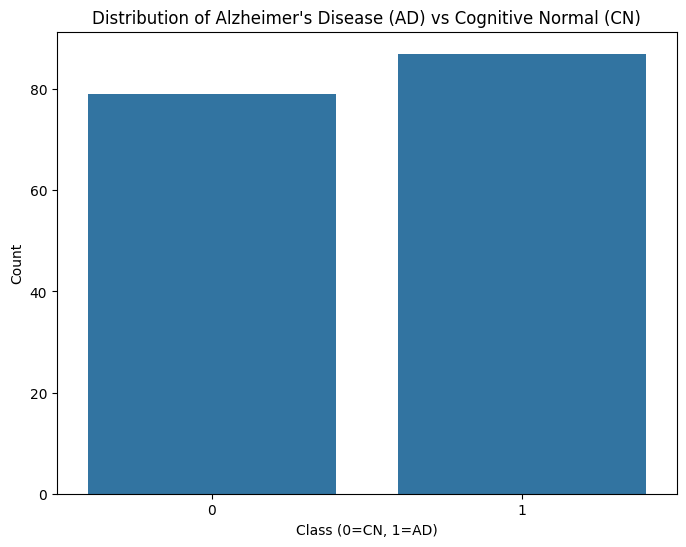


=== SHAPE ANALYSIS ===
Sample 0: (128, 4453, 3)
Sample 1: (128, 9804, 3)
Sample 2: (128, 6577, 3)
Sample 3: (128, 6917, 3)
Sample 4: (128, 4734, 3)

Common shapes: (128, 4453, 3)    1
(128, 9804, 3)    1
(128, 6577, 3)    1
(128, 6917, 3)    1
(128, 4734, 3)    1
Name: count, dtype: int64

=== DATA PREPROCESSING ===
Loading and preprocessing data...
Processed 20 samples
Processed 40 samples
Processed 60 samples
Processed 80 samples
Processed 100 samples
Processed 120 samples
Processed 140 samples
Processed 160 samples

Final dataset shapes:
X shape: (166, 128, 128, 3)
y shape: (166,)
Unique shapes in dataset: (128, 128, 3)    166
Name: count, dtype: int64

=== DATASET SPLITTING ===
Training set: (99, 128, 128, 3), (99,)
Validation set: (33, 128, 128, 3), (33,)
Test set: (34, 128, 128, 3), (34,)

Training class distribution: [47 52]
Validation class distribution: [16 17]
Test class distribution: [16 18]

Class weights: {0: np.float64(1.053191489361702), 1: np.float64(0.9519230769230769

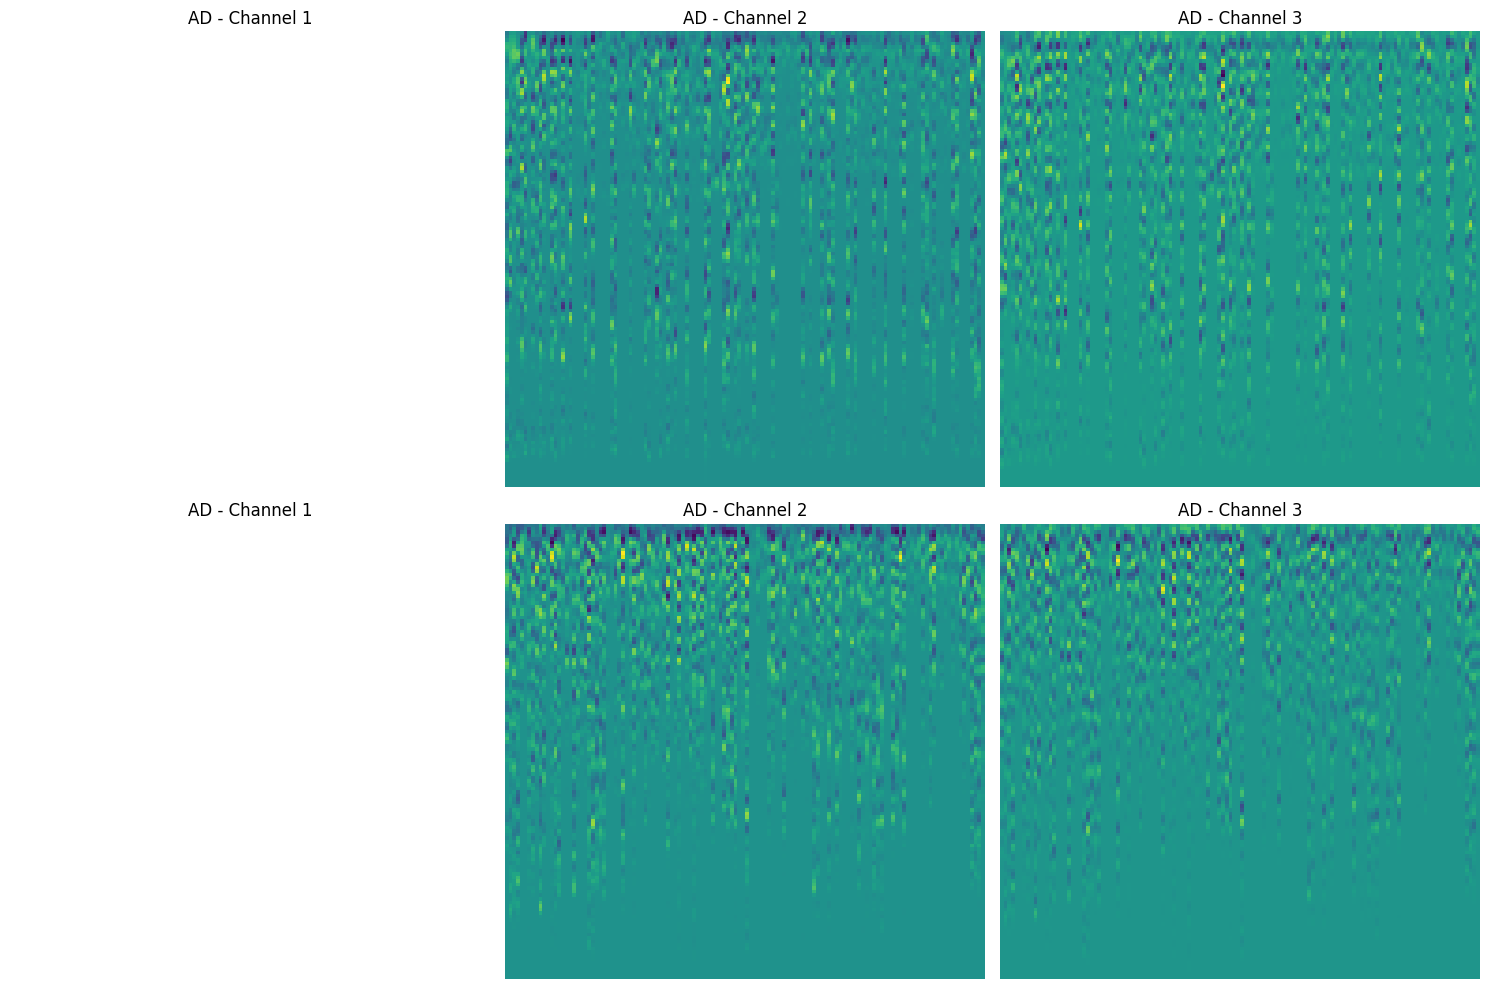


=== SAVING PROCESSED DATA ===
Preprocessed data saved!
Files created:
- /content/X_train.npy
- /content/X_val.npy
- /content/X_test.npy
- /content/y_train.npy
- /content/y_val.npy
- /content/y_test.npy

Data summary saved to /content/data_summary.pkl

=== PREPROCESSING COMPLETE ===
Data is ready for model training!
To prepare external test data, use the prepare_external_test_data() function


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import cv2
from tensorflow.keras.utils import to_categorical
import os
import warnings
warnings.filterwarnings('ignore')

# Load the processed dataset
df = pd.read_csv('/content/alzheimers_dataset_processed.csv')
print(f"Dataset loaded with {len(df)} samples")

# EDA - Exploratory Data Analysis
print("\n=== EXPLORATORY DATA ANALYSIS ===")
print("Dataset Info:")
print(df.info())
print("\nLabel Distribution:")
print(df['label'].value_counts())
print(f"\nClass balance: {df['label'].mean():.2f} (1=AD, 0=CN)")

# Visualize label distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label')
plt.title('Distribution of Alzheimer\'s Disease (AD) vs Cognitive Normal (CN)')
plt.xlabel('Class (0=CN, 1=AD)')
plt.ylabel('Count')
plt.show()

# Function to load and combine the three channels
def load_three_channel_data(log_mel_path, delta_path, delta_delta_path):
    """
    Load and combine log-mel, delta, and delta-delta features into 3-channel data
    """
    try:
        # Load each feature
        log_mel = np.load(log_mel_path)
        delta = np.load(delta_path)
        delta_delta = np.load(delta_delta_path)

        # Handle different dimensions
        # Ensure all arrays are 2D (time, features)
        if log_mel.ndim == 1:
            log_mel = log_mel.reshape(-1, 1)
        elif log_mel.ndim > 2:
            log_mel = log_mel.reshape(log_mel.shape[0], -1)

        if delta.ndim == 1:
            delta = delta.reshape(-1, 1)
        elif delta.ndim > 2:
            delta = delta.reshape(delta.shape[0], -1)

        if delta_delta.ndim == 1:
            delta_delta = delta_delta.reshape(-1, 1)
        elif delta_delta.ndim > 2:
            delta_delta = delta_delta.reshape(delta_delta.shape[0], -1)

        # Ensure all have the same shape by truncating to minimum
        min_time = min(log_mel.shape[0], delta.shape[0], delta_delta.shape[0])
        min_features = min(log_mel.shape[1], delta.shape[1], delta_delta.shape[1])

        # Trim to same size
        log_mel = log_mel[:min_time, :min_features]
        delta = delta[:min_time, :min_features]
        delta_delta = delta_delta[:min_time, :min_features]

        # Stack along the channel dimension
        three_channel = np.stack([log_mel, delta, delta_delta], axis=-1)

        return three_channel
    except Exception as e:
        print(f"Error loading {log_mel_path}: {e}")
        return None

# Check shapes of first few samples
print("\n=== SHAPE ANALYSIS ===")
sample_shapes = []
for idx in range(min(5, len(df))):
    row = df.iloc[idx]
    data = load_three_channel_data(row['log_mel_path'], row['delta_path'], row['delta_delta_path'])
    if data is not None:
        sample_shapes.append(data.shape)
        print(f"Sample {idx}: {data.shape}")

print(f"\nCommon shapes: {pd.Series(sample_shapes).value_counts()}")

# Function to normalize data manually (avoiding StandardScaler issues)
def normalize_data(data):
    """
    Normalize data to [0, 1] range manually
    """
    # Normalize each channel independently
    normalized_data = np.zeros_like(data)
    for channel in range(data.shape[-1]):
        channel_data = data[:, :, channel]
        min_val = np.min(channel_data)
        max_val = np.max(channel_data)
        if max_val - min_val > 0:
            normalized_data[:, :, channel] = (channel_data - min_val) / (max_val - min_val)
        else:
            normalized_data[:, :, channel] = channel_data
    return normalized_data

# Function to standardize data manually (mean=0, std=1)
def standardize_data_manual(data):
    """
    Standardize data manually to have zero mean and unit variance
    """
    standardized_data = np.zeros_like(data)
    for channel in range(data.shape[-1]):
        channel_data = data[:, :, channel]
        mean_val = np.mean(channel_data)
        std_val = np.std(channel_data)
        if std_val > 0:
            standardized_data[:, :, channel] = (channel_data - mean_val) / std_val
        else:
            standardized_data[:, :, channel] = channel_data - mean_val
    return standardized_data

# Function to resize data to fixed size
def resize_data(data, target_shape=(128, 128)):
    """
    Resize 3D data (time, features, channels) to fixed size
    """
    # Transpose to (channels, time, features) for easier processing
    data = np.transpose(data, (2, 0, 1))

    resized_channels = []
    for channel in data:
        # Handle case where one dimension is 1
        if channel.shape[0] == 1 or channel.shape[1] == 1:
            # Use different interpolation for edge cases
            resized = cv2.resize(channel, (target_shape[1], target_shape[0]),
                               interpolation=cv2.INTER_NEAREST)
        else:
            resized = cv2.resize(channel, (target_shape[1], target_shape[0]),
                               interpolation=cv2.INTER_LINEAR)
        resized_channels.append(resized)

    # Stack and transpose back to (time, features, channels)
    resized_data = np.stack(resized_channels, axis=-1)
    return resized_data

# Load and preprocess all data
print("\n=== DATA PREPROCESSING ===")
X = []
y = []
valid_indices = []
file_paths = []  # Keep track of file paths for reference

target_shape = (128, 128)  # You can adjust this based on your data

print("Loading and preprocessing data...")
successful_loads = 0
for idx, row in df.iterrows():
    try:
        # Load three-channel data
        data = load_three_channel_data(row['log_mel_path'], row['delta_path'], row['delta_delta_path'])

        if data is not None and data.size > 0:
            # Resize to fixed size
            data_resized = resize_data(data, target_shape)

            # Standardize the data
            data_standardized = standardize_data_manual(data_resized)

            X.append(data_standardized)
            y.append(row['label'])
            valid_indices.append(idx)
            file_paths.append(row['log_mel_path'])
            successful_loads += 1

            if successful_loads % 20 == 0:
                print(f"Processed {successful_loads} samples")

    except Exception as e:
        print(f"Error processing sample {idx}: {e}")

X = np.array(X)
y = np.array(y)

print(f"\nFinal dataset shapes:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Check for any remaining shape inconsistencies
if len(X) > 0:
    unique_shapes = [x.shape for x in X]
    print(f"Unique shapes in dataset: {pd.Series(unique_shapes).value_counts()}")
else:
    print("ERROR: No data loaded successfully!")
    raise ValueError("No data loaded successfully. Check your data files.")

# Ensure all samples have the same shape
if len(set(unique_shapes)) > 1:
    print("WARNING: Inconsistent shapes found. Truncating to minimum dimensions...")
    # Find minimum dimensions
    min_shape = np.min([np.array(shape) for shape in unique_shapes], axis=0)
    print(f"Standardizing to shape: {min_shape}")

    # Truncate all samples to minimum dimensions
    X_truncated = []
    for sample in X:
        truncated_sample = sample[:min_shape[0], :min_shape[1], :min_shape[2]]
        X_truncated.append(truncated_sample)
    X = np.array(X_truncated)

# Split the data
print("\n=== DATASET SPLITTING ===")
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Check class distribution in splits
print(f"\nTraining class distribution: {np.bincount(y_train)}")
print(f"Validation class distribution: {np.bincount(y_val)}")
print(f"Test class distribution: {np.bincount(y_test)}")

# Calculate class weights for imbalanced dataset
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print(f"\nClass weights: {class_weight_dict}")

# Visualize some samples
print("\n=== SAMPLE VISUALIZATION ===")
if len(X_train) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Plot samples from both classes
    ad_indices = np.where(y_train == 1)[0]
    cn_indices = np.where(y_train == 0)[0]

    for i in range(min(2, len(ad_indices))):
        idx = ad_indices[i]
        # Plot AD sample
        axes[i, 0].imshow(X_train[idx, :, :, 0], aspect='auto', cmap='viridis')
        axes[i, 0].set_title(f'AD - Channel 1')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(X_train[idx, :, :, 1], aspect='auto', cmap='viridis')
        axes[i, 1].set_title(f'AD - Channel 2')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(X_train[idx, :, :, 2], aspect='auto', cmap='viridis')
        axes[i, 2].set_title(f'AD - Channel 3')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Save preprocessed data
print("\n=== SAVING PROCESSED DATA ===")
np.save('/content/X_train.npy', X_train)
np.save('/content/X_val.npy', X_val)
np.save('/content/X_test.npy', X_test)
np.save('/content/y_train.npy', y_train)
np.save('/content/y_val.npy', y_val)
np.save('/content/y_test.npy', y_test)

print("Preprocessed data saved!")
print("Files created:")
print("- /content/X_train.npy")
print("- /content/X_val.npy")
print("- /content/X_test.npy")
print("- /content/y_train.npy")
print("- /content/y_val.npy")
print("- /content/y_test.npy")

# Create a summary dictionary
data_summary = {
    'X_train_shape': X_train.shape,
    'X_val_shape': X_val.shape,
    'X_test_shape': X_test.shape,
    'y_train_shape': y_train.shape,
    'y_val_shape': y_val.shape,
    'y_test_shape': y_test.shape,
    'class_weights': class_weight_dict,
    'target_shape': target_shape,
    'successful_samples': len(X)
}

import pickle
with open('/content/data_summary.pkl', 'wb') as f:
    pickle.dump(data_summary, f)

print("\nData summary saved to /content/data_summary.pkl")

# Function to prepare external test data
def prepare_external_test_data(test_directory, target_shape=(128, 128)):
    """
    Prepare external test data that follows the same structure
    test_directory should have AD and CN subdirectories
    """
    print(f"Preparing external test data from: {test_directory}")

    ad_path = os.path.join(test_directory, 'AD')
    cn_path = os.path.join(test_directory, 'CN')

    test_files = []
    test_labels = []

    # Collect AD files (label = 1)
    if os.path.exists(ad_path):
        for file in os.listdir(ad_path):
            if file.endswith('.npy'):
                test_files.append(os.path.join(ad_path, file))
                test_labels.append(1)

    # Collect CN files (label = 0)
    if os.path.exists(cn_path):
        for file in os.listdir(cn_path):
            if file.endswith('.npy'):
                test_files.append(os.path.join(cn_path, file))
                test_labels.append(0)

    print(f"Found {len(test_files)} test files ({sum(test_labels)} AD, {len(test_labels)-sum(test_labels)} CN)")

    # Process test files
    X_test_ext = []
    y_test_ext = []
    valid_test_files = []

    for i, (file_path, label) in enumerate(zip(test_files, test_labels)):
        try:
            # For external test data, we need to generate the three channels
            # Since we don't have precomputed delta/delta-delta, we'll compute them here
            mel_spectrogram = np.load(file_path)

            # Ensure it's 2D
            if mel_spectrogram.ndim == 1:
                mel_spectrogram = mel_spectrogram.reshape(-1, 1)
            elif mel_spectrogram.ndim > 2:
                mel_spectrogram = mel_spectrogram.reshape(mel_spectrogram.shape[0], -1)

            # Compute log-mel (or just use the mel as is if log causes issues)
            try:
                log_mel = np.log(mel_spectrogram + 1e-8)
            except:
                log_mel = mel_spectrogram  # Fallback if log fails

            # Compute delta features (simple difference)
            delta = np.diff(mel_spectrogram, axis=0, prepend=mel_spectrogram[0:1, :])

            # Compute delta-delta features
            delta_delta = np.diff(delta, axis=0, prepend=delta[0:1, :])

            # Ensure all have the same shape
            min_time = min(log_mel.shape[0], delta.shape[0], delta_delta.shape[0])
            min_features = min(log_mel.shape[1], delta.shape[1], delta_delta.shape[1])

            # Trim to same size
            log_mel = log_mel[:min_time, :min_features]
            delta = delta[:min_time, :min_features]
            delta_delta = delta_delta[:min_time, :min_features]

            # Stack channels
            three_channel = np.stack([log_mel, delta, delta_delta], axis=-1)

            # Resize
            three_channel_resized = resize_data(three_channel, target_shape)

            # Standardize
            three_channel_standardized = standardize_data_manual(three_channel_resized)

            X_test_ext.append(three_channel_standardized)
            y_test_ext.append(label)
            valid_test_files.append(file_path)

            if i % 10 == 0:
                print(f"Processed {i+1}/{len(test_files)} test files")

        except Exception as e:
            print(f"Error processing test file {file_path}: {e}")

    X_test_ext = np.array(X_test_ext)
    y_test_ext = np.array(y_test_ext)

    print(f"External test set shape: {X_test_ext.shape}")
    print(f"External test labels shape: {y_test_ext.shape}")

    return X_test_ext, y_test_ext, valid_test_files

print("\n=== PREPROCESSING COMPLETE ===")
print("Data is ready for model training!")
print("To prepare external test data, use the prepare_external_test_data() function")

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import cv2
from tensorflow.keras.utils import to_categorical
import os
from glob import glob

# Load the existing dataset (166 samples for training)
df = pd.read_csv('/content/alzheimers_dataset.csv')
print(f"Training dataset loaded with {len(df)} samples")

# Function to compute delta features
def compute_delta(features, N=2):
    """
    Compute delta features using gradient approximation
    features: 2D array (time, features)
    N: window size for delta computation
    """
    from scipy.ndimage import convolve1d

    # Create delta coefficients
    weights = np.arange(-N, N+1)
    weights = weights/np.sum(weights**2)  # Normalize

    # Apply convolution along time axis
    delta = convolve1d(features, weights, axis=0, mode='nearest')
    return delta

# Function to process spectrogram (only delta and delta-delta)
def process_spectrogram(file_path):
    """
    Load spectrogram and compute delta and delta-delta features
    Returns: original, delta, delta_delta
    """
    # Load the mel spectrogram
    mel_spectrogram = np.load(file_path)

    # Ensure it's 2D (time, features)
    if mel_spectrogram.ndim == 3:
        mel_spectrogram = mel_spectrogram.squeeze()

    # Compute delta
    delta = compute_delta(mel_spectrogram)

    # Compute delta-delta
    delta_delta = compute_delta(delta)

    return mel_spectrogram, delta, delta_delta

# Create directories for saving processed features
processed_dir = '/content/Processed_Features'
os.makedirs(processed_dir, exist_ok=True)
os.makedirs(os.path.join(processed_dir, 'original'), exist_ok=True)
os.makedirs(os.path.join(processed_dir, 'delta'), exist_ok=True)
os.makedirs(os.path.join(processed_dir, 'delta_delta'), exist_ok=True)

# Process all training files
print("Processing training spectrograms...")

# Add new columns for processed file paths
df['original_path'] = ''
df['delta_path'] = ''
df['delta_delta_path'] = ''

for idx, row in df.iterrows():
    file_path = row['file_path']

    try:
        # Process the spectrogram
        original, delta, delta_delta = process_spectrogram(file_path)

        # Create new file paths
        base_name = os.path.basename(file_path).replace('.npy', '')
        original_path = os.path.join(processed_dir, 'original', f'{base_name}_original.npy')
        delta_path = os.path.join(processed_dir, 'delta', f'{base_name}_delta.npy')
        delta_delta_path = os.path.join(processed_dir, 'delta_delta', f'{base_name}_delta_delta.npy')

        # Save processed features
        np.save(original_path, original)
        np.save(delta_path, delta)
        np.save(delta_delta_path, delta_delta)

        # Update DataFrame
        df.at[idx, 'original_path'] = original_path
        df.at[idx, 'delta_path'] = delta_path
        df.at[idx, 'delta_delta_path'] = delta_delta_path

        if idx % 20 == 0:
            print(f"Processed {idx}/{len(df)} files")

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

print("Feature extraction completed!")

# Save updated dataset
df.to_csv('/content/alzheimers_dataset_processed.csv', index=False)
print("Updated dataset saved to /content/alzheimers_dataset_processed.csv")

# Function to load and combine the three channels
def load_three_channel_data(original_path, delta_path, delta_delta_path):
    """
    Load and combine original, delta, and delta-delta features into 3-channel data
    """
    try:
        # Load each feature
        original = np.load(original_path)
        delta = np.load(delta_path)
        delta_delta = np.load(delta_delta_path)

        # Ensure all have the same shape
        min_time = min(original.shape[0], delta.shape[0], delta_delta.shape[0])
        min_features = min(original.shape[1], delta.shape[1], delta_delta.shape[1])

        # Trim/pad to same size
        original = original[:min_time, :min_features]
        delta = delta[:min_time, :min_features]
        delta_delta = delta_delta[:min_time, :min_features]

        # Stack along the channel dimension
        three_channel = np.stack([original, delta, delta_delta], axis=-1)

        return three_channel
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Function to normalize data (fix for the previous errors)
def normalize_data(data):
    """
    Normalize data to [0, 1] range to avoid standardization issues
    """
    # Handle per channel normalization
    normalized_data = np.zeros_like(data)

    for channel in range(data.shape[-1]):
        channel_data = data[:, :, channel]
        min_val = np.min(channel_data)
        max_val = np.max(channel_data)

        # Avoid division by zero
        if max_val - min_val > 0:
            normalized_data[:, :, channel] = (channel_data - min_val) / (max_val - min_val)
        else:
            normalized_data[:, :, channel] = channel_data  # Keep as is if constant

    return normalized_data

# Function to resize data to fixed size
def resize_data(data, target_shape=(128, 128)):
    """
    Resize 3D data (time, features, channels) to fixed size
    """
    # Transpose to (channels, time, features) for easier processing
    data = np.transpose(data, (2, 0, 1))

    resized_channels = []
    for channel in data:
        # Resize using OpenCV
        resized = cv2.resize(channel, (target_shape[1], target_shape[0]),
                           interpolation=cv2.INTER_LINEAR)
        resized_channels.append(resized)

    # Stack and transpose back to (time, features, channels)
    resized_data = np.stack(resized_channels, axis=-1)
    return resized_data

# Load and preprocess all training data
print("\n=== TRAINING DATA PREPROCESSING ===")
X_train = []
y_train = []
valid_indices = []

target_shape = (128, 128)

print("Loading and preprocessing training data...")
for idx, row in df.iterrows():
    try:
        # Load three-channel data
        data = load_three_channel_data(row['original_path'], row['delta_path'], row['delta_delta_path'])

        if data is not None:
            # Resize to fixed size
            data_resized = resize_data(data, target_shape)

            # Normalize the data
            data_normalized = normalize_data(data_resized)

            X_train.append(data_normalized)
            y_train.append(row['label'])
            valid_indices.append(idx)

            if idx % 20 == 0:
                print(f"Processed {idx}/{len(df)} training samples")

    except Exception as e:
        print(f"Error processing training sample {idx}: {e}")

X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"\nTraining data shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Check for any remaining shape inconsistencies
if len(X_train) > 0:
    unique_shapes = [x.shape for x in X_train]
    print(f"Unique shapes in training data: {pd.Series(unique_shapes).value_counts()}")

# Split training data into train and validation sets
print("\n=== DATASET SPLITTING ===")
from sklearn.model_selection import train_test_split

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

print(f"Final Training set: {X_train_final.shape}, {y_train_final.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

# Check class distribution in splits
print(f"\nTraining class distribution: {np.bincount(y_train_final)}")
print(f"Validation class distribution: {np.bincount(y_val)}")

# Calculate class weights for imbalanced dataset
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_final),
    y=y_train_final
)
class_weight_dict = dict(enumerate(class_weights))
print(f"\nClass weights: {class_weight_dict}")

# Save preprocessed training and validation data
print("\n=== SAVING PROCESSED TRAINING DATA ===")
np.save('/content/X_train_final.npy', X_train_final)
np.save('/content/X_val.npy', X_val)
np.save('/content/y_train_final.npy', y_train_final)
np.save('/content/y_val.npy', y_val)

print("Preprocessed training data saved!")
print("Files created:")
print("- /content/X_train_final.npy")
print("- /content/X_val.npy")
print("- /content/y_train_final.npy")
print("- /content/y_val.npy")

# Create a summary dictionary
data_summary = {
    'X_train_shape': X_train_final.shape,
    'X_val_shape': X_val.shape,
    'y_train_shape': y_train_final.shape,
    'y_val_shape': y_val.shape,
    'class_weights': class_weight_dict,
    'target_shape': target_shape
}

import pickle
with open('/content/data_summary.pkl', 'wb') as f:
    pickle.dump(data_summary, f)

print("\nData summary saved to /content/data_summary.pkl")

# Now process your separate test directory
print("\n=== PROCESSING SEPARATE TEST DIRECTORY ===")
# Please specify your test directory path
test_base_path = '/content/drive/MyDrive/AD/Test_Mel_Spectrograms'  # Update this path

# Check if test directory exists
if os.path.exists(test_base_path):
    print(f"Test directory found: {test_base_path}")

    # Create test data structure
    test_data = []
    test_labels = []

    # Process AD test files
    ad_test_path = os.path.join(test_base_path, 'AD')
    cn_test_path = os.path.join(test_base_path, 'CN')

    test_files = []
    test_file_labels = []

    if os.path.exists(ad_test_path):
        ad_test_files = glob(os.path.join(ad_test_path, '*.npy'))
        test_files.extend(ad_test_files)
        test_file_labels.extend([1] * len(ad_test_files))
        print(f"Found {len(ad_test_files)} AD test files")

    if os.path.exists(cn_test_path):
        cn_test_files = glob(os.path.join(cn_test_path, '*.npy'))
        test_files.extend(cn_test_files)
        test_file_labels.extend([0] * len(cn_test_files))
        print(f"Found {len(cn_test_files)} CN test files")

    # Process test files
    print("Processing test files...")
    for i, (file_path, label) in enumerate(zip(test_files, test_file_labels)):
        try:
            # Process the spectrogram
            original, delta, delta_delta = process_spectrogram(file_path)

            # Save processed features
            base_name = os.path.basename(file_path).replace('.npy', '')
            original_path = os.path.join(processed_dir, 'original', f'{base_name}_test_original.npy')
            delta_path = os.path.join(processed_dir, 'delta', f'{base_name}_test_delta.npy')
            delta_delta_path = os.path.join(processed_dir, 'delta_delta', f'{base_name}_test_delta_delta.npy')

            np.save(original_path, original)
            np.save(delta_path, delta)
            np.save(delta_delta_path, delta_delta)

            # Load three-channel data
            data = load_three_channel_data(original_path, delta_path, delta_delta_path)

            if data is not None:
                # Resize to fixed size
                data_resized = resize_data(data, target_shape)

                # Normalize the data
                data_normalized = normalize_data(data_resized)

                test_data.append(data_normalized)
                test_labels.append(label)

                if i % 10 == 0:
                    print(f"Processed {i}/{len(test_files)} test samples")

        except Exception as e:
            print(f"Error processing test sample {file_path}: {e}")

    X_test = np.array(test_data)
    y_test = np.array(test_labels)

    print(f"\nTest data shapes:")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")

    # Save test data
    np.save('/content/X_test.npy', X_test)
    np.save('/content/y_test.npy', y_test)
    print("Test data saved to /content/X_test.npy and /content/y_test.npy")

else:
    print(f"Test directory not found: {test_base_path}")
    print("You'll need to process your test data separately.")

print("\n=== PREPROCESSING COMPLETE ===")
print("Training data is ready for model training!")

Training dataset loaded with 166 samples
Processing training spectrograms...
Processed 0/166 files
Processed 20/166 files
Processed 40/166 files
Processed 60/166 files
Processed 80/166 files
Processed 100/166 files
Processed 120/166 files
Processed 140/166 files
Processed 160/166 files
Feature extraction completed!
Updated dataset saved to /content/alzheimers_dataset_processed.csv

=== TRAINING DATA PREPROCESSING ===
Loading and preprocessing training data...
Processed 0/166 training samples
Processed 20/166 training samples
Processed 40/166 training samples
Processed 60/166 training samples
Processed 80/166 training samples
Processed 100/166 training samples
Processed 120/166 training samples
Processed 140/166 training samples
Processed 160/166 training samples

Training data shapes:
X_train shape: (166, 128, 128, 3)
y_train shape: (166,)
Unique shapes in training data: (128, 128, 3)    166
Name: count, dtype: int64

=== DATASET SPLITTING ===
Final Training set: (124, 128, 128, 3), (1